In [14]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [15]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [16]:
data_dir= '/content/drive/MyDrive/PlantDisease/Data'
categories = os.listdir(data_dir)

# load images and Labels
images=[]
labels=[]

for category in categories:
  print(category)
  folder_path=os.path.join(data_dir,category)
  for img_file in os.listdir(folder_path):
    img_path=os.path.join(folder_path,img_file)
    img=cv2.imread(img_path)
    if img is not None:
      img = cv2.resize(img, (64, 64)) #Resize to uniform size
      images.append(img)
      labels.append(category)

#convert images and labels to numpy arrays
images = np.array(images)

Tomato___Early_blight
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___Target_Spot
Tomato___Late_blight
Tomato___healthy
Tomato___Bacterial_spot


In [29]:
#convert to numpy arrays
x=np.array(images)
y=np.array(labels)

print("Labels: ",np.unique(y))
print("Data Shape:" ,x.shape)


Labels:  ['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Target_Spot' 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Tomato_mosaic_virus' 'Tomato___healthy']
Data Shape: (13071, 64, 64, 3)


Class Distribution
Tomato___Tomato_Yellow_Leaf_Curl_Virus    2016
Tomato___Early_blight                     1930
Tomato___healthy                          1926
Tomato___Late_blight                      1880
Tomato___Target_Spot                      1827
Tomato___Tomato_mosaic_virus              1790
Tomato___Bacterial_spot                   1702
Name: count, dtype: int64


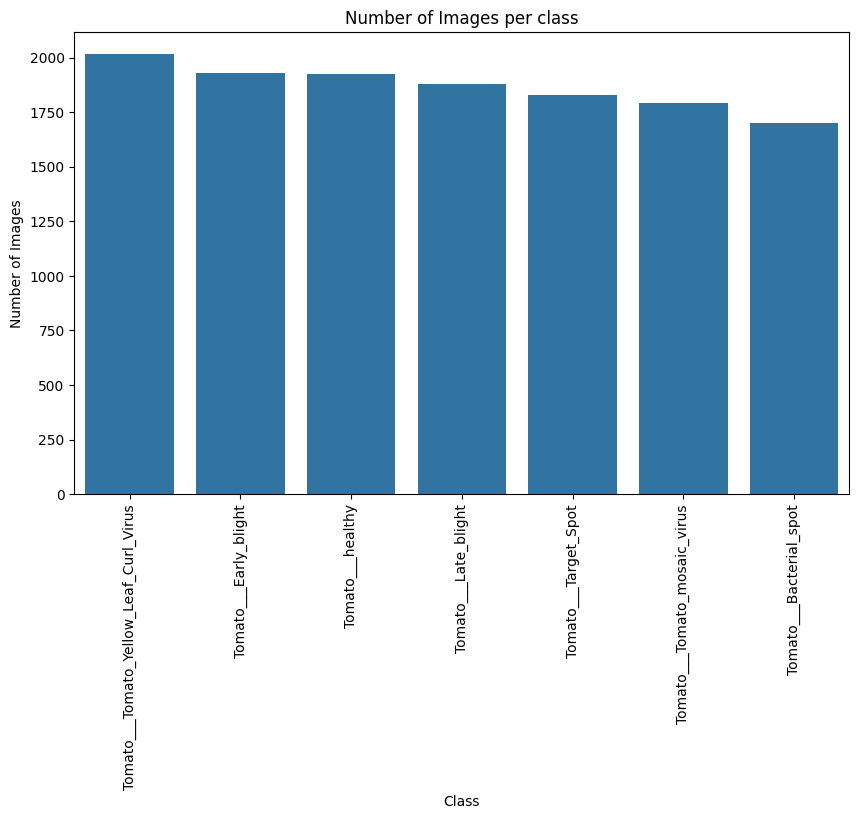

In [18]:
class_counts=pd.Series(y).value_counts()
print("Class Distribution")
print(class_counts)

#plot class Distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index,y=class_counts.values)
plt.xticks(rotation=90)
plt.title("Number of Images per class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [19]:
#remove corrupted images
valid_images=[]
valid_labels=[]
for img,label in zip(x,y):
  if img.shape == (64,64,3):
    valid_images.append(img)
    valid_labels.append(label)
x=np.array(valid_images)
y=np.array(valid_labels)

print("Cleaned Data Shape",x.shape)

Cleaned Data Shape (13071, 64, 64, 3)


In [20]:
#Encode labels
le=LabelEncoder()
y_encoded=le.fit_transform(y)

#save class names for later use
class_names=le.classes_
class_names

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Target_Spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U38')

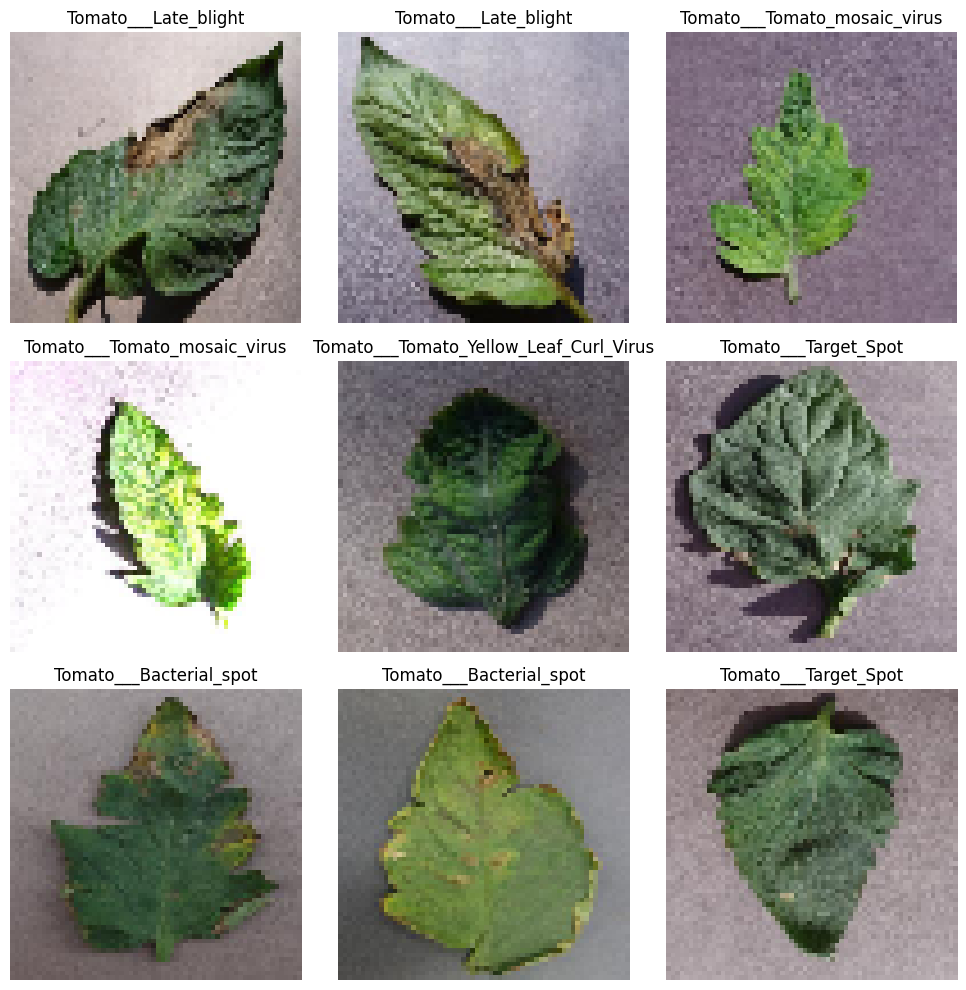

In [21]:
import random

plt.figure(figsize=(10,10))
for i in range(9):
  idx=random.randint(0,len(x))
  plt.subplot(3,3,i+1)
  plt.imshow(cv2.cvtColor(x[idx],cv2.COLOR_BGR2RGB))
  plt.title(class_names[y_encoded[idx]])
  plt.axis("off")
plt.tight_layout()
plt.show()

In [22]:
def extract_color_histogram(image,bins=(8,8,8)):

  image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  hist=cv2.calcHist([image],[0,1,2],None,bins,[0,256,0,256,0,256])
  hist=cv2.normalize(hist,hist).flatten()
  return hist
hist_features=[extract_color_histogram(img) for img in x]
x_features=np.array(hist_features)



In [23]:
x_features.shape

(13071, 512)

In [24]:
#choose model
model=SVC(kernel='rbf',C=10,gamma='scale')

In [26]:
#Train/Test Split
x_train,x_test,y_train,y_test=train_test_split(x_features,y_encoded,test_size=0.2,random_state=42)

#train model
model.fit(x_train,y_train)

#predict
y_pred=model.predict(x_test)

Accuracy: 0.9686424474187381
F1 Score: 0.968573032844181


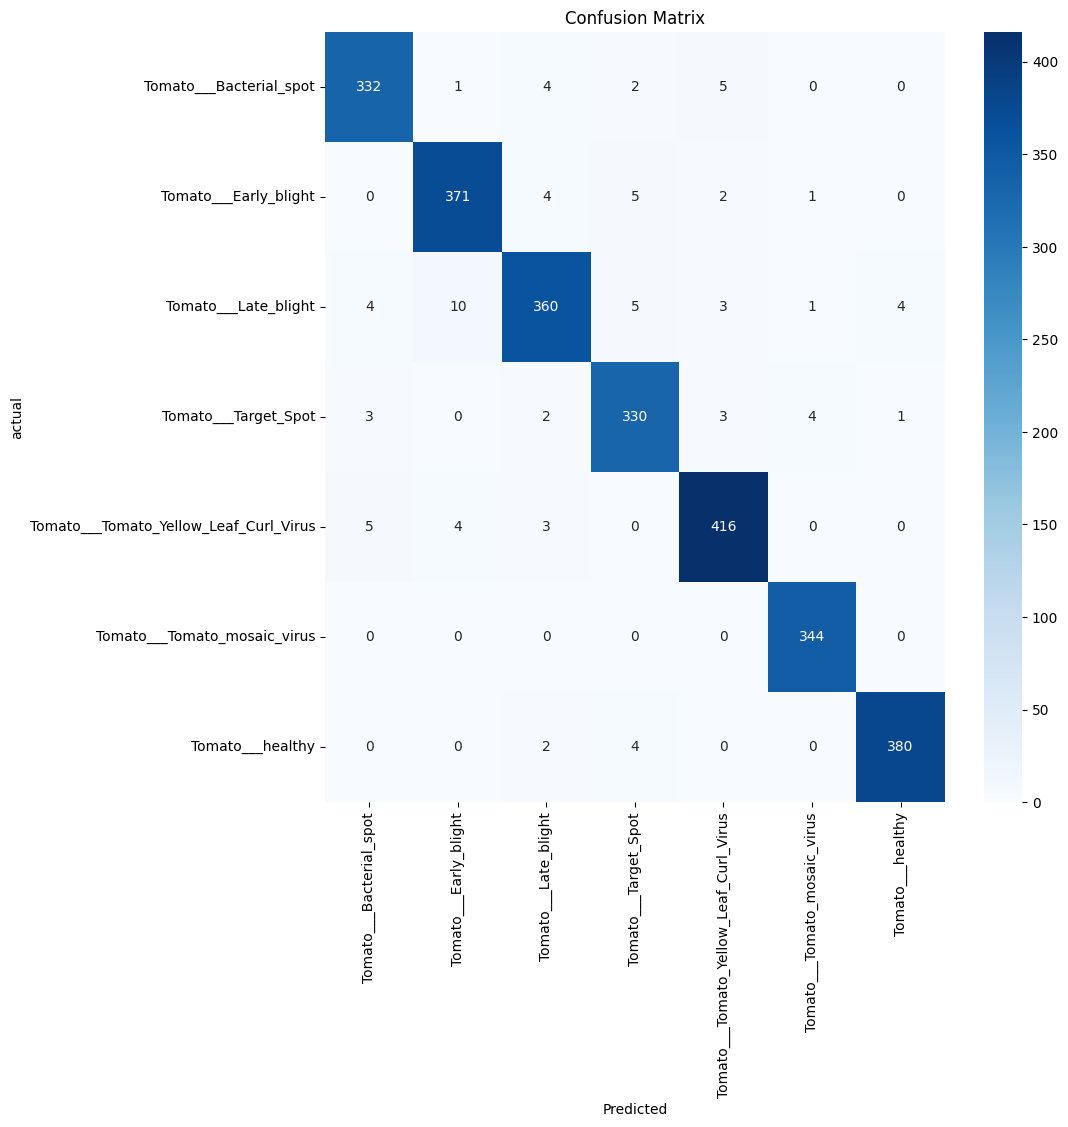

In [27]:
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,classification_report

#Accuracy
acc=accuracy_score(y_test,y_pred)
print("Accuracy:",acc)

#F1 score
f1=f1_score(y_test,y_pred,average='weighted')
print("F1 Score:",f1)

#Confusion Matrix
cm=confusion_matrix(y_test,y_pred)

#plot confusion matrix

plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('actual')
plt.title("Confusion Matrix")
plt.show()



In [28]:
#classification report
print("classification Report:")
print(classification_report(y_test,y_pred,target_names=class_names))

classification Report:
                                        precision    recall  f1-score   support

               Tomato___Bacterial_spot       0.97      0.97      0.97       344
                 Tomato___Early_blight       0.96      0.97      0.96       383
                  Tomato___Late_blight       0.96      0.93      0.94       387
                  Tomato___Target_Spot       0.95      0.96      0.96       343
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.97      0.97       428
          Tomato___Tomato_mosaic_virus       0.98      1.00      0.99       344
                      Tomato___healthy       0.99      0.98      0.99       386

                              accuracy                           0.97      2615
                             macro avg       0.97      0.97      0.97      2615
                          weighted avg       0.97      0.97      0.97      2615

